In [4]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("data/data_visualization.csv", low_memory=False)

In [8]:
# 메모리 최적화
def optimize_dataframe(df):
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = df[col].astype(np.float32) # 실수형 다운캐스팅
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = df[col].astype(np.int32) # 정수형 다운캐스팅
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category") # 문자열 -> 범주형
    return df
df = optimize_dataframe(df)

In [10]:
narcotics_types = {"NARCOTICS", "OTHER NARCOTIC VIOLATION"}

# 타겟 변수 생성
df["is_narcotics"] = np.where(df["Primary Type"].isin(narcotics_types), 1, 0).astype(np.uint8)

In [14]:
# Unknown을 결측치로 변환
df["District"] = df["District"].replace('unknown', np.nan)
df["Ward"] = df["Ward"].replace('unknown', np.nan)

# int는 결측치를 가질 수 없어 float로 전환
df["District"] = df["District"].astype(np.float32)
df["Ward"] = df["Ward"].astype(np.float32)

In [16]:
# category 타입을 float으로 변환
df['Y Coordinate'] = pd.to_numeric(df['Y Coordinate'], errors='coerce')

# 이상치 제거
df = df[df['Y Coordinate'] >= 10000]

In [18]:
# 분석과 예측에 불필요한 컬럼 제거 (Date 추가)
drop_cols = ["Case Number", "ID", "Date", "Latitude","Block", "Longitude", "Location", "Primary Type", "IUCR", "FBI Code", "Description"]
df = df.drop(columns=drop_cols)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6168073 entries, 0 to 6170812
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Location Description  category
 1   Arrest                bool    
 2   Domestic              bool    
 3   Beat                  int32   
 4   District              float32 
 5   Ward                  float32 
 6   X Coordinate          category
 7   Y Coordinate          float64 
 8   Year                  int32   
 9   Community Area Code   int32   
 10  is_narcotics          uint8   
dtypes: bool(2), category(2), float32(2), float64(1), int32(3), uint8(1)
memory usage: 303.4 MB


In [22]:
df.isnull().sum()

Location Description      0
Arrest                    0
Domestic                  0
Beat                      0
District                 48
Ward                    461
X Coordinate              0
Y Coordinate              0
Year                      0
Community Area Code       0
is_narcotics              0
dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [26]:
X = df.drop(columns="is_narcotics").copy()
y = df["is_narcotics"]

In [28]:
# category 타입 인코딩
for col in X.select_dtypes(include='category').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [30]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [32]:
# 클래스 불균형 비율 계산
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# RandomForest 모델 정의
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# 모델 학습
rf.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

scale_pos_weight: 8.15
              precision    recall  f1-score   support

           0       0.96      0.96      0.96   1098641
           1       0.70      0.68      0.69    134864

    accuracy                           0.93   1233505
   macro avg       0.83      0.82      0.83   1233505
weighted avg       0.93      0.93      0.93   1233505



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|0.96|0.96|0.96|
|1 (마약 범죄)|0.70|0.68|0.69|
|Marco Average|0.83|0.82|0.83|
|Weighted Average|0.93|0.93|0.93|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|RandomForest|93|83|

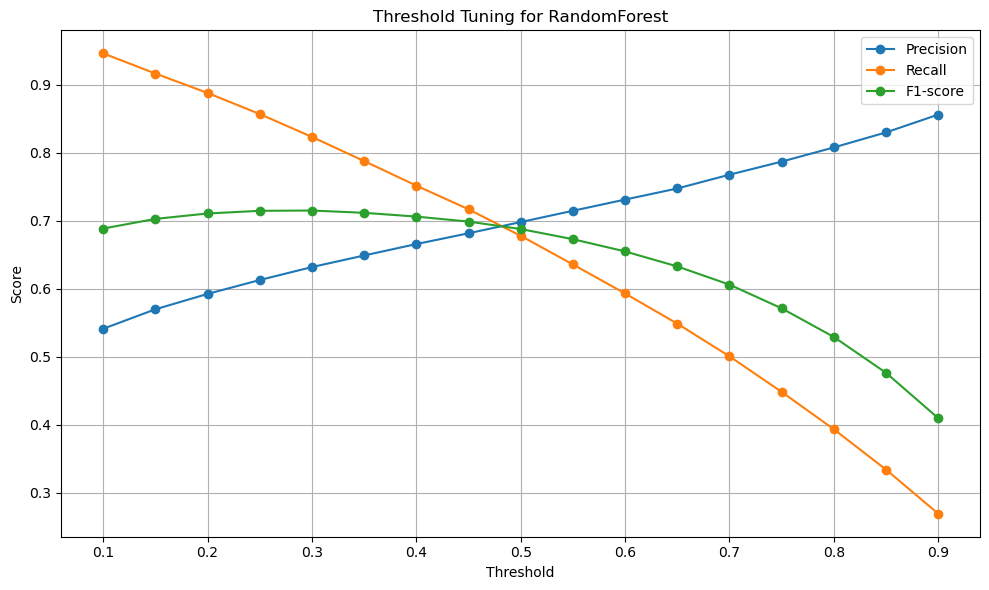

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 예측 확률 (마약 클래스: 1에 대한 확률)
y_scores = rf.predict_proba(X_test)[:, 1]

# 임계값 후보
thresholds = np.arange(0.1, 0.91, 0.05)

# 결과 저장
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1-score', marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for RandomForest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# 예측 확률 얻기
y_scores = rf.predict_proba(X_test)[:, 1]

# 최적의 threshold로 커스텀 예측
optimal_threshold = 0.6
y_pred = (y_scores >= optimal_threshold).astype(int)

# 평가
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96   1098641
           1       0.73      0.60      0.66    134864

    accuracy                           0.93   1233505
   macro avg       0.84      0.78      0.81   1233505
weighted avg       0.93      0.93      0.93   1233505



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|0.95|0.97|0.96|
|1 (마약 범죄)|0.73|0.60|0.66|
|Marco Average|0.84|0.78|0.81|
|Weighted Average|0.93|0.93|0.93|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|RandomForest|93|81|

- 정밀도(Precision)이 0.73으로 올랐지만 임계치(Threshold)를 0.5로 하는 것이 더 좋음

- 재현율(Recall)이 더 높고, F1-score도 더 높음 → 마약 범죄를 더 잘 포착

- 정밀도(Precision)도 심하게 떨어지지 않음 (0.73 → 0.70)

- Macro F1 기준으로도 성능이 더 좋음